<a href="https://colab.research.google.com/github/akshit61/Colibri/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook is used to perform Exploratory Data Analysis of the wind turbines dataset.

 **Objective:**   

*   Understand data schema
*   Check for null values
*   Calculate statistics for each turbine id
*   Perform anomaly detection on a sample dataset



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.colab import files


In [32]:
url = 'https://raw.githubusercontent.com/akshit61/Colibri/refs/heads/main/Data/Original/data_group_1.csv'
df_grp1 = pd.read_csv(url)
df_grp1.head()

,timestamp,turbine_id,wind_speed,wind_direction,power_output
0,2022-03-01 00:00:00,1,11.8,169,2.7
1,2022-03-01 00:00:00,2,11.6,24,2.2
2,2022-03-01 00:00:00,3,13.8,335,2.3
3,2022-03-01 00:00:00,4,12.8,238,1.9
4,2022-03-01 00:00:00,5,11.4,103,3.5


In [25]:
#check for null values
df_grp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       3720 non-null   object 
 1   turbine_id      3720 non-null   int64  
 2   wind_speed      3720 non-null   float64
 3   wind_direction  3720 non-null   int64  
 4   power_output    3720 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 145.4+ KB


**No records are null in the dataset. Lets check for descriptive stats.**

In [27]:
df_grp1['timestamp'] = pd.to_datetime(df_grp1['timestamp'])
df_grp1['date'] = df_grp1['timestamp'].dt.date
df_grp1['hour'] = df_grp1['timestamp'].dt.hour

unique_turbines = df_grp1['turbine_id'].unique()
all_hours = range(24)

# Create a DataFrame to track missing hours
missing_hours = []

# Loop through each turbine ID
for turbine in unique_turbines:
    # Filter data for the current turbine
    turbine_data = df_grp1[df_grp1['turbine_id'] == turbine]

    # Check for missing hours for each date
    for date in turbine_data['date'].unique():
        # Filter data for the current date
        date_data = turbine_data[turbine_data['date'] == date]

        # Find missing hours
        present_hours = date_data['hour'].unique()
        missing = set(all_hours) - set(present_hours)

        # Add missing hours to the list
        if missing:
            for hour in missing:
                missing_hours.append({'turbine_id': turbine, 'date': date, 'missing_hour': hour})

# Convert the list to a DataFrame for easier analysis
missing_hours_df = pd.DataFrame(missing_hours)

# Display the missing hours, if any
print(missing_hours_df)

Empty DataFrame
Columns: []
Index: []


**No hourly records for each of the turbine id is missing between 2022-03-01 and 2022-03-31.**

In [26]:
#Describe dataframe
df_grp1.describe()

,turbine_id,wind_speed,wind_direction,power_output
count,3720.000000,3720.000000,3720.000000,3720.000000
mean,3.000000,11.973737,179.830376,2.988575
std,1.414404,1.772146,104.510606,0.869452
min,1.000000,9.000000,0.000000,1.500000
25%,2.000000,10.400000,89.000000,2.300000
50%,3.000000,12.000000,180.000000,3.000000
75%,4.000000,13.500000,269.000000,3.700000
max,5.000000,15.000000,359.000000,4.500000


**Also no record in the dataset is negative, so it does not require further cleaning.**

**Now that we have checked the data is cleaned I will look for any anomalies in the sample dataset. This will include checking a rolling mean and standard deviation of power_output for a 24 hour window to see if any of the turbines data points have moved drastically compared to the same hour previous day.**

In [29]:

# Group by turbine_id and hour, and calculate mean and std for each group
hourly_stats = df_grp1.groupby(['turbine_id', 'hour'])['power_output'].agg(['mean', 'std']).reset_index()
hourly_stats.rename(columns={'mean': 'hourly_mean_output', 'std': 'hourly_std_dev_output'}, inplace=True)

# Merge the hourly statistics back to the original dataset
data = df_grp1.merge(hourly_stats, on=['turbine_id', 'hour'])

# Identify anomalies based on hourly statistics
data['hourly_anomaly'] = (
    (data['power_output'] < data['hourly_mean_output'] - 2 * data['hourly_std_dev_output']) |
    (data['power_output'] > data['hourly_mean_output'] + 2 * data['hourly_std_dev_output'])
)

# Count anomalies for each turbine and hour
hourly_anomalies_per_turbine = data[data['hourly_anomaly']].groupby(['turbine_id', 'hour']).size()

# Display anomalies for each turbine and hour
print(hourly_anomalies_per_turbine)


turbine_id  hour
1           3       1
            5       1
            12      1
            21      1
2           7       3
            17      1
            22      1
4           3       1
            7       1
            11      1
            20      1
            21      3
5           5       1
            10      2
dtype: int64


As we see here, some data points lie outside the normal distribution of Mean - 2 * Standard Deviation for the same hour each day. Lets plot the graph for turbine id 1 bold text.

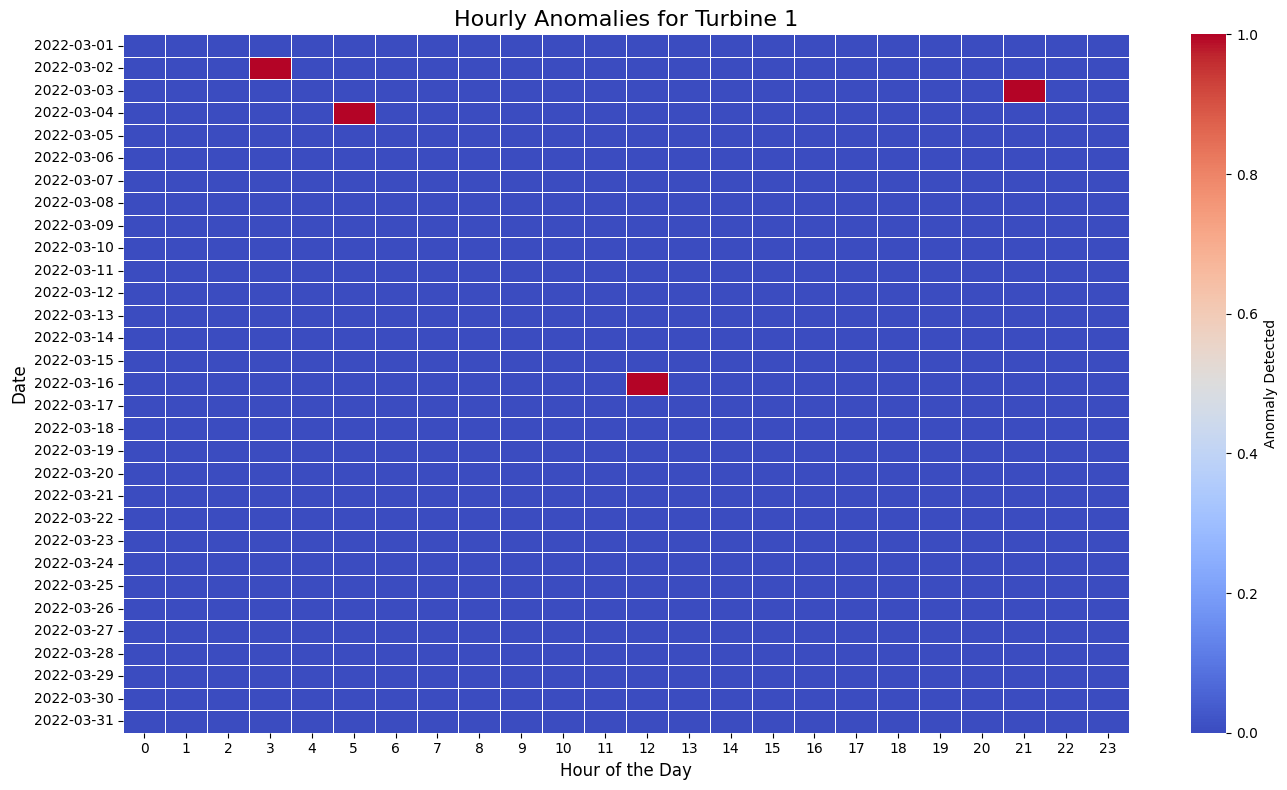

In [30]:
# Filter data for a specific turbine, e.g., Turbine 1
turbine_id = 1
turbine_data = data[data['turbine_id'] == turbine_id]

# Create a pivot table for heatmap (hours as columns, dates as rows)
pivot_data = turbine_data.pivot_table(
    index='date', columns='hour', values='hourly_anomaly', aggfunc='any'
)

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot_data, cmap='coolwarm', cbar_kws={'label': 'Anomaly Detected'}, linewidths=0.5
)
plt.title(f'Hourly Anomalies for Turbine {turbine_id}', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

**As per the requirement, I conclude the EDA here.The data pipeline notebook contains steps to automate these steps and store the output in a database(mocked as csv).**